<a href="https://colab.research.google.com/github/EriProject/Multimodal_Biometrics/blob/master/Iris_Subsystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
import tensorflow as tf

NUM_CLASSES = 40
CHANNELS = 3
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']
EARLY_STOP_PATIENCE = 3

BATCH_SIZE_TESTING = 1

STEPS_PER_EPOCH_TRAINING = training set/ batch size

In [0]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.applications import imagenet_utils
from keras.layers.core import Dense, Flatten, Dropout

Using TensorFlow backend.


In [0]:
modelNew = Sequential()
vgg16_model = Sequential()
vgg16_model = ResNet50(include_top = False,  weights = 'imagenet')
vgg16_model.summary()
type(vgg16_model)
i=0
for layer in vgg16_model.layers:   # just exclude last layer from copying
  i=i+1
print('layers: ',i)


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:

import os
import tempfile

def add_regularization(reg_model, regularizer=tf.keras.regularizers.l2(0.001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return reg_model

    for layer in reg_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = reg_model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    reg_model.save_weights(tmp_weights_path)

    # load the model from the config
    reg_model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    reg_model.load_weights(tmp_weights_path, by_name=True)
    return reg_model


In [0]:
#Still not talking about our train/test data or any pre-processing.
#from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,Conv2D, MaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
model = Sequential()
# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
Resnet_Model=ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet') #resnet_weights_path)
model.add(Resnet_Model)
# 2nd layer as Dense for 40-class classification using SoftMax activation
model.add(Dense(NUM_CLASSES,activation = DENSE_LAYER_ACTIVATION)) #,  kernel_initializer='random_normal'
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False
model.summary()
type(model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 40)                81960     
Total params: 23,669,672
Trainable params: 81,960
Non-trainable params: 23,587,712
_________________________________________________________________


keras.engine.sequential.Sequential

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD
model=add_regularization(model)
#sgdd= optimizers.SGD(lr = 0.01, momentum = 0.9, clipvalue=0.5 ,decay = 1e-6,nesterov = True) #, clipvalue=0.5 #,decay = 1e-6
# model.compile(optimizer =sgd, loss = loss='categorical_crossentropy', metrics = ['accuracy']) #sgd
model.compile(Adam(lr= 0.0001),loss='mean_squared_error', metrics=['accuracy']) #
img_width, img_height = 224, 224
from keras import backend as K  
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_size = IMAGE_RESIZE

NUM_EPOCHS = 50
BATCH_SIZE_TRAINING = 13 #100
BATCH_SIZE_VALIDATION =13 #100

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING =  160 // BATCH_SIZE_TRAINING #10
STEPS_PER_EPOCH_VALIDATION = 40 // BATCH_SIZE_VALIDATION

# Train data generator
train_datagen = ImageDataGenerator( width_shift_range=0.1,
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False)
Data_classes=[]
for i in range (14,225):
   Data_classes.append(i)

#validation data generator
validate_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# read the images from respective directories
# read training images
# train_batches= ImageDataGenerator.flow_from_directory(train_path,target_size=(224,224), Data_classes, )

train_data_dir = '/content/drive/My Drive/Final_Fusion/Iris_Data/Train' 
#/content/drive/My Drive/Indian Database/Forty/Train'
validation_data_dir = '/content/drive/My Drive/Final_Fusion/Iris_Data/Test'
#'/content/drive/My Drive/Indian Database/Forty/Test'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE_TRAINING,
    shuffle =True,
    class_mode='categorical')

# read validation images
validation_generator = validate_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    shuffle=True,
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical')

 #/content/drive/My Drive/OUR SDP/Iris Images/IIT_Left_Normalized/Test

Found 160 images belonging to 40 classes.
Found 40 images belonging to 40 classes.


In [0]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(13, 13, 13, 4)

In [0]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'BestChoice.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
print(STEPS_PER_EPOCH_TRAINING)

12


In [0]:
import tensorflow
from tensorflow.keras.models import model_from_json
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING, #
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        shuffle=True,
        #callbacks=[cb_checkpointer, cb_early_stopper]
)
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Final_Fusion/SAVED MODELS/Iris Model/model_1.json", "w") as json_file:
    json_file.write(model_json)
    print("[INFO] the model is saved into jason file.")
# serialize weights to HDF5
print("[INFO] Saving the model weights...")
model.save_weights('/content/drive/My Drive/Final_Fusion/SAVED MODELS/Iris Model/adam_50epoch_iris.h5')


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
12/12 [==============================] - 5s 385ms/step - loss: 0.0995 - accuracy: 0.1156 - val_loss: 0.0968 - val_accuracy: 0.2564
Epoch 2/50
12/12 [==============================] - 3s 219ms/step - loss: 0.0876 - accuracy: 0.6259 - val_loss: 0.0887 - val_accuracy: 0.4359
Epoch 3/50
12/12 [==============================] - 3s 209ms/step - loss: 0.0762 - accuracy: 0.8231 - val_loss: 0.0794 - val_accuracy: 0.5897
Epoch 4/50
12/12 [==============================] - 3s 208ms/step - loss: 0.0697 - accuracy: 0.8980 - val_loss: 0.0715 - val_accuracy: 0.8462
Epoch 5/50
12/12 [==============================] - 2s 207ms/step - loss: 0.0643 - accuracy: 0.9456 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 6/50
12/12 [==============================] - 2s 205ms/step - loss: 0.0603 - accuracy: 0.9864 - val_loss: 0.0592 - val_accuracy: 0.9744
Epoch 7/50
12/12 [==============================] - 2s 208ms/step - loss

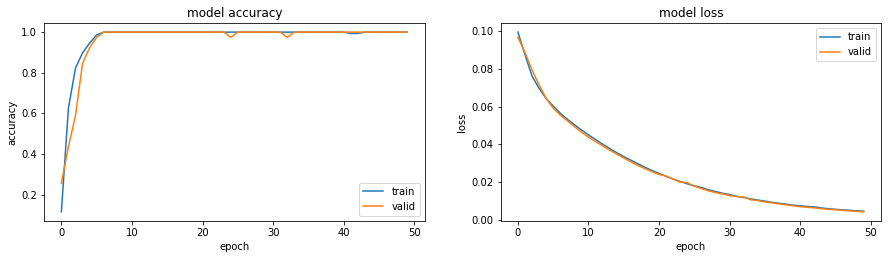

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [0]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder
# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator= validate_datagen.flow_from_directory(
    directory ='/content/drive/My Drive/Final_Fusion/Iris_Data/Test',
    # '/content/drive/My Drive/Face_D/Test',
    target_size = (image_size, image_size),
    batch_size = 1,#BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

test_generator_random=validate_datagen.flow_from_directory(
    directory ='/content/drive/My Drive/Final_Fusion/Iris_Data/Iris_Outsider',
    # '/content/drive/My Drive/Face_D/Test',
    target_size = (image_size, image_size),
    batch_size = 1,#BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)



Found 40 images belonging to 40 classes.
Found 40 images belonging to 1 classes.


In [0]:
import numpy as np
test_generator.reset()
from sklearn.metrics import confusion_matrix 

actual_labels = test_generator.classes
print(actual_labels)
print(test_generator.filenames)
pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)
random_pred=model.predict_generator(test_generator_random, steps = len(test_generator_random), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)
 
 # confusion matrix, all corrected classified classes are in the diagonal entries of the matrix
 # the colomuns are actual labels vs Rows as predicted Labels

cm = confusion_matrix(actual_labels,predicted_class_indices)
print(cm)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
['Person_01/Person_1_5_L.bmp', 'Person_02/Person_2_5_L.bmp', 'Person_03/Person_3_5_L.bmp', 'Person_04/Person_4_5_L.bmp', 'Person_05/Person_5_5_L.bmp', 'Person_06/Person_6_5_L.bmp', 'Person_07/Person_7_5_L.bmp', 'Person_08/Person_8_5_L.bmp', 'Person_09/Person_9_5_L.bmp', 'Person_10/Person_10_5_L.bmp', 'Person_11/Person_11_5_L.bmp', 'Person_12/Person_12_5_L.bmp', 'Person_13/Person_13_4_L.bmp', 'Person_14/Person_14_5_L.bmp', 'Person_15/Person_15_5_L.bmp', 'Person_16/Person_16_5_L.bmp', 'Person_17/Person_17_5_L.bmp', 'Person_18/Person_18_5_L.bmp', 'Person_19/Person_19_5_L.bmp', 'Person_20/Person_20_5_L.bmp', 'Person_21/Person_21_5_L.bmp', 'Person_22/Person_22_5_L.bmp', 'Person_23/Person_23_5_L.bmp', 'Person_24/Person_24_5_L.bmp', 'Person_25/Person_25_5_L.bmp', 'Person_26/Person_26_5_L.bmp', 'Person_27/Person_27_5_L.bmp', 'Person_28/Person_28_5_L.bmp', 'Person_29/Person